# LAPD crimes database: 2010-present

### Import data tools

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import geojson
import json
import jenkspy
import numpy as np
from earthpy import clip as cl
from altair import datum
import altair as alt
alt.renderers.enable('notebook')
import altair_latimes as lat
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')
pd.options.display.max_columns = 50
pd.options.display.max_rows = 1000

### Read crimes CSV downloaded from LA City data portal

In [2]:
# https://data.lacity.org/A-Safe-City/Crime-Data-from-2010-to-Present/63jg-8b9z
src = pd.read_csv('/Users/mhustiles/data/data/LA/Crime_Data_from_2010_to_Present.csv')

In [3]:
crimes = src

In [4]:
crimes.columns = crimes.columns.str.strip().str.lower()\
.str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

### These data are super messy...

In [5]:
crimes.rename(columns = { 
'dr_no':'record_id',
'date_rptd':'date_reported',
'date_occ':'date_occurred',
'time_occ':'time_occurred',
'area':'division',
'area_name':'division_name',
'rpt_dist_no':'reporting_district',
'part_1-2':'part_type',
'crm_cd':'crime_code',
'crm_cd_desc':'crime_code_description',
'mocodes':'modus_operandi_code',
'vict_age':'victim_age',
'vict_sex':'victim_sex',
'vict_descent':'victim_descent',
'premis_cd':'premises_code',
'premis_desc':'premises_description',
'weapon_used_cd':'weapon_code',
'weapon_desc':'weapon_description',
'status':'status_code',
'status_desc':'status_code_description',
'crm_cd_1':'crm_cd_1',
'crm_cd_2':'crm_cd_2',
'crm_cd_3':'crm_cd_3',
'crm_cd_4':'crm_cd_4',
'location':'address',
'cross_street':'cross_street',
'lat':'latitude',
'lon':'longitide',
 }, inplace = True)

### ... contunued

In [6]:
crimes['date_reported'] = crimes['date_reported'].str.replace(' 12:00:00 AM','')
crimes['date_occurred'] = crimes['date_occurred'].str.replace(' 12:00:00 AM','')
crimes['date_occurred'] = pd.to_datetime(crimes['date_occurred'], format='%m/%d/%Y')
crimes['year'] = crimes['date_occurred'].dt.year
crimes['quarter'] = crimes['date_occurred'].dt.quarter
crimes['day'] = crimes['date_occurred'].dt.day
crimes['month'] = crimes['date_occurred'].dt.month
crimes['weekday'] = crimes['date_occurred'].dt.weekday_name
crimes['monthname'] = crimes['date_occurred'].dt.month_name()

In [7]:
crimes[[ 'record_id', 
    'time_occurred', 
    'division', 
    'reporting_district', 
    'part_type',
    'crm_cd_1',
    'crm_cd_2',
    'crm_cd_3',
    'crm_cd_4',
    'crime_code', 
    'premises_code', 
    'weapon_code',
    'year',
    'quarter',
    'day',
    'month', ]] = crimes[[
    'record_id', 
    'time_occurred', 
    'division', 
    'reporting_district', 
    'part_type',
    'crm_cd_1',
    'crm_cd_2',
    'crm_cd_3',
    'crm_cd_4',
    'crime_code', 
    'premises_code', 
    'weapon_code',
    'year',
    'quarter',
    'day',
    'month',]].astype(str)

In [8]:
descent_recode = { 'A':"Asian",'B':"Black",'C':"Asian",'D':"Asian",'F':"Asian",'G':"Asian",\
                 'H':"Hispanic",'I':"American Indian/Alaskan Native",'J':"Asian",\
                 'K':"Asian",'L':"Asian",'O':"Other",'P':"Asian",'S':"Asian",\
                 'U':"Asian",'V':"Asian",'W':"White",'X':"Other",'Z':"Asian" }

In [9]:
crimes['descent_description'] = crimes['victim_descent'].map(descent_recode)

In [10]:
crimes['premises_code'] = crimes['premises_code'].str.replace('.0','', regex=False)
crimes['premises_code'] = crimes['premises_code'].str.replace('.0','', regex=False)
crimes['crm_cd_1'] = crimes['crm_cd_1'].str.replace('.0','', regex=False)
crimes['crm_cd_2'] = crimes['crm_cd_2'].str.replace('.0','', regex=False)

In [11]:
crimes['premises_description'] = crimes['premises_description'].str.capitalize()
crimes['crime_code_description'] = crimes['crime_code_description'].str.capitalize()
crimes['weapon_description'] = crimes['weapon_description'].str.capitalize()

In [12]:
monthnames = ['January','February','March','April','May','June','July','August','September','October','November','December']

In [13]:
crimes['time_occurred'] = crimes['time_occurred'].str.replace('.0','', regex=False)
crimes['time_occurred'] = crimes['time_occurred'].str.zfill(4)
crimes['hour'] = crimes['time_occurred'].str[:2]
crimes['minute'] = crimes['time_occurred'].str[2:]
crimes = crimes[crimes['hour'] != '0n']
crimes = crimes[crimes['hour'] != '24']

In [14]:
homicides = crimes[crimes['crime_code_description'].str.contains('CRIMINAL HOMICIDE', na=False)]

---

## Now that it's clean, what can we learn from this data?

### Share of crimes by UCR type

In [15]:
crimes['part_type'].value_counts('normalize').round(3)*100

1    55.4
2    44.6
Name: part_type, dtype: float64

### Cases involving suspects or victimes defined by LAPD as 'homeless'

In [16]:
mocrimes = crimes.dropna(subset=['modus_operandi_code'])

In [17]:
mocodes = pd.read_csv('mo_codes.csv')
mocodes.head()

,mo_code,mo_code_description
0,0100,Suspect Impersonate
1,0101,Aid victim
2,0102,Blind
3,0103,Crippled
4,0104,Customer


### Isolating just cases involving homeless people

In [18]:
# MO Code 1218 is to be used when a victim is homeless
# MO Code 2004 is to be used when a suspect is homeless
mocodes_homeless = mocodes[mocodes['mo_code_description'].str.lower().str.contains('homeless')]
mocodes_homeless.head()

,mo_code,mo_code_description
361,1218,Victim was Homeless/Transient
521,2004,Suspect is homeless/transient


### Limit homeless crime data to recent years to account for coding issues

In [19]:
homeless_dates = ['2015','2016', '2017', '2018', '2019']

### Various filters

In [20]:
# My street
rubens = crimes[crimes['address'].str.contains('RUBENS', na=False)]
# Crimes tagged by specific modus operandi code
bunco = crimes[crimes['modus_operandi_code'].str.contains('0800', na=False) ]

#Homeless people codes
homeless_victims = crimes[(crimes['modus_operandi_code'].str.contains('1218', na=False)) & (crimes['year'].isin(homeless_dates))]
homeless_suspects = crimes[(crimes['modus_operandi_code'].str.contains('2004', na=False)) & (crimes['year'].isin(homeless_dates))]
homeless_homicides = homeless_victims[(homeless_victims['crime_code_description']\
                    .str.contains('Criminal homicide', na=False))\
                    & (homeless_victims['year'].isin(homeless_dates))]

### How many cases do we have involving homeless people? 

In [21]:
len(homeless_victims)

16269

In [22]:
len(homeless_suspects)

34062

In [23]:
homeless_homicides.head()

,record_id,date_reported,date_occurred,time_occurred,division,division_name,reporting_district,part_type,crime_code,crime_code_description,modus_operandi_code,victim_age,victim_sex,victim_descent,premises_code,premises_description,weapon_code,weapon_description,status_code,status_code_description,crm_cd_1,crm_cd_2,crm_cd_3,crm_cd_4,address,cross_street,latitude,longitide,year,quarter,day,month,weekday,monthname,descent_description,hour,minute
1041616,151511171,05/09/2015,2015-05-09,1340,15,N Hollywood,1525,1,110,Criminal homicide,0430 1100 0906 1402 1420 0449 0529 1809 1218 1414,25,M,H,247,Car wash,101.0,Revolver,AA,Adult Arrest,110,nan,nan,nan,6400 LAUREL CANYON BL,NaN,34.1867,-118.3965,2015,2,9,5,Saturday,May,Hispanic,13,40
1041833,150118604,08/11/2015,2015-08-11,0144,1,Central,147,1,110,Criminal homicide,1218 1100 0430 1202,60,M,B,102,Sidewalk,102.0,Hand gun,AA,Adult Arrest,110,nan,nan,nan,300 E 5TH ST,NaN,34.0453,-118.2443,2015,3,11,8,Tuesday,August,Black,01,44
1043126,151507992,03/11/2015,2015-03-11,1115,15,N Hollywood,1532,1,110,Criminal homicide,1310 0350 1218,48,M,W,101,Street,500.0,Unknown weapon/other weapon,IC,Invest Cont,110,nan,nan,nan,12300 SYLVAN ST,NaN,34.1849,-118.4025,2015,1,11,3,Wednesday,March,White,11,15
1067365,150222118,12/07/2015,2015-12-06,2200,2,Rampart,217,1,110,Criminal homicide,1402 0411 1218,66,M,B,102,Sidewalk,200.0,Knife with blade 6inches or less,IC,Invest Cont,110,998,nan,nan,ALVARADO ST,BELLEVUE AV,34.0729,-118.2664,2015,4,6,12,Sunday,December,Black,22,00
1088363,151423154,08/30/2015,2015-08-30,0209,14,Pacific,1412,1,110,Criminal homicide,1218 1100 0906 0430 1409 1407 1402,26,M,B,102,Sidewalk,102.0,Hand gun,AA,Adult Arrest,110,998,nan,nan,300 OCEAN FRONT WK,NaN,33.9933,-118.4765,2015,3,30,8,Sunday,August,Black,02,09


In [24]:
homeless_homicides_years = homeless_homicides.groupby\
(['year','division_name', 'premises_description','weapon_description']).agg('size').reset_index(name='total')

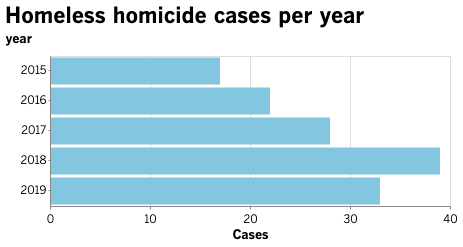

In [25]:
alt.Chart(homeless_homicides_years).mark_bar().encode(
    y=alt.Y('year:N', axis=alt.Axis(format='', tickCount=5)),
    x=alt.X("sum(total):Q", title="Cases", axis=alt.Axis(format='', tickCount=5))
).properties(height=150, width=400, columns=3, title='Homeless homicide cases per year')

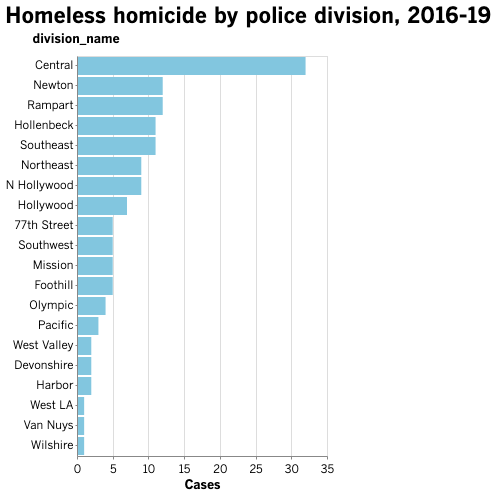

In [26]:
alt.Chart(homeless_homicides_years).mark_bar().encode(
    y=alt.Y('division_name:N',
        sort=alt.EncodingSortField(
            field="total",  # The field to use for the sort
            op="sum",  # The operation to run on the field prior to sorting
            order="descending"  # The order to sort in
        ), axis=alt.Axis(format='', tickCount=5)),
    x=alt.X("sum(total):Q", title="Cases", axis=alt.Axis(format='', tickCount=5))
).properties(height=400, width=250, columns=3, title='Homeless homicide by police division, 2016-19')

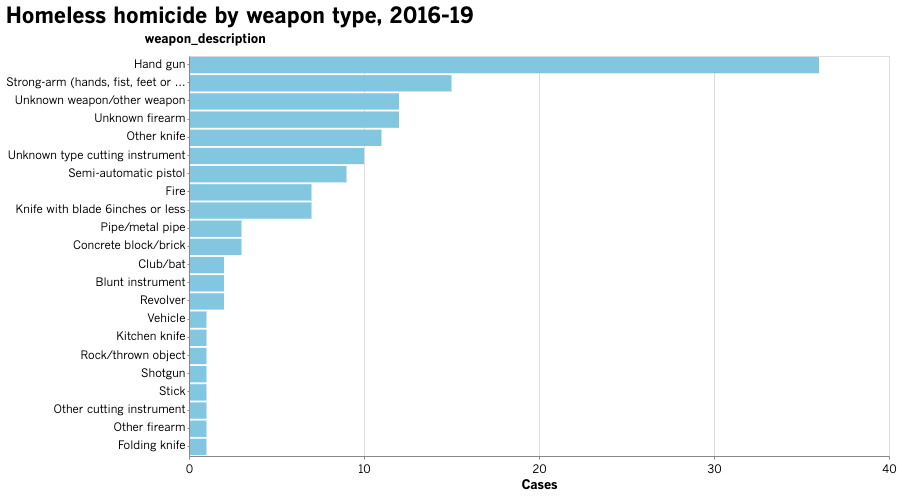

In [27]:
alt.Chart(homeless_homicides_years).mark_bar().encode(
    y=alt.Y('weapon_description:N',
        sort=alt.EncodingSortField(
            field="total",  # The field to use for the sort
            op="sum",  # The operation to run on the field prior to sorting
            order="descending"  # The order to sort in
        ), axis=alt.Axis(format='', tickCount=5)),
    x=alt.X("sum(total):Q", title="Cases", axis=alt.Axis(format='', tickCount=5))
).properties(height=400, width=700, columns=3, title='Homeless homicide by weapon type, 2016-19')

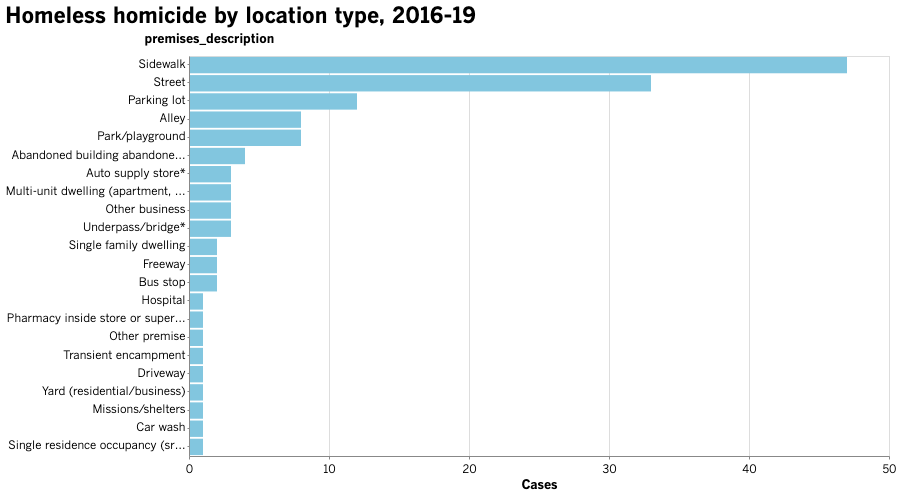

In [28]:
alt.Chart(homeless_homicides_years).mark_bar().encode(
    y=alt.Y('premises_description:N',
        sort=alt.EncodingSortField(
            field="total",  # The field to use for the sort
            op="sum",  # The operation to run on the field prior to sorting
            order="descending"  # The order to sort in
        ), axis=alt.Axis(format='', tickCount=5)),
    x=alt.X("sum(total):Q", title="Cases", axis=alt.Axis(format='', tickCount=5))
).properties(height=400, width=700, columns=3, title='Homeless homicide by location type, 2016-19')

---

## Homeless victims

In [29]:
homeless_year_victim = homeless_victims.groupby(['year', 'division_name'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)
homeless_year_victim.head()

,year,division_name,total
85,2019,Central,1600
64,2018,Central,1404
1,2015,Central,922
22,2016,Central,807
43,2017,Central,677


In [30]:
homeless_year_victim = homeless_victims.groupby(['year', 'division_name'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)
homeless_year_victim.head(10)

,year,division_name,total
85,2019,Central,1600
64,2018,Central,1404
1,2015,Central,922
22,2016,Central,807
43,2017,Central,677
76,2018,Rampart,338
72,2018,Newton,296
97,2019,Rampart,281
93,2019,Newton,275
55,2017,Rampart,262


### What types of crimes are most common for homeless victims?

In [31]:
homeless_cases_victim = homeless_victims.groupby(['crime_code_description'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)

In [32]:
homeless_cases_victim.head()

,crime_code_description,total
2,"Assault with deadly weapon, aggravated assault",4010
4,Battery - simple assault,2938
55,Robbery,1820
69,Theft plain - petty ($950 & under),1672
37,Intimate partner - simple assault,1644


### Where do crimes involving homeless victims occur? 

In [33]:
homeless_victims['division_name'].value_counts('normalize').round(2)*100

Central        33.0
Rampart         7.0
Newton          6.0
Pacific         5.0
N Hollywood     5.0
Hollywood       4.0
Southwest       4.0
Olympic         4.0
Van Nuys        3.0
Harbor          3.0
West LA         3.0
77th Street     3.0
Southeast       3.0
Northeast       3.0
Hollenbeck      3.0
Foothill        2.0
Mission         2.0
West Valley     2.0
Devonshire      2.0
Wilshire        2.0
Topanga         1.0
Name: division_name, dtype: float64

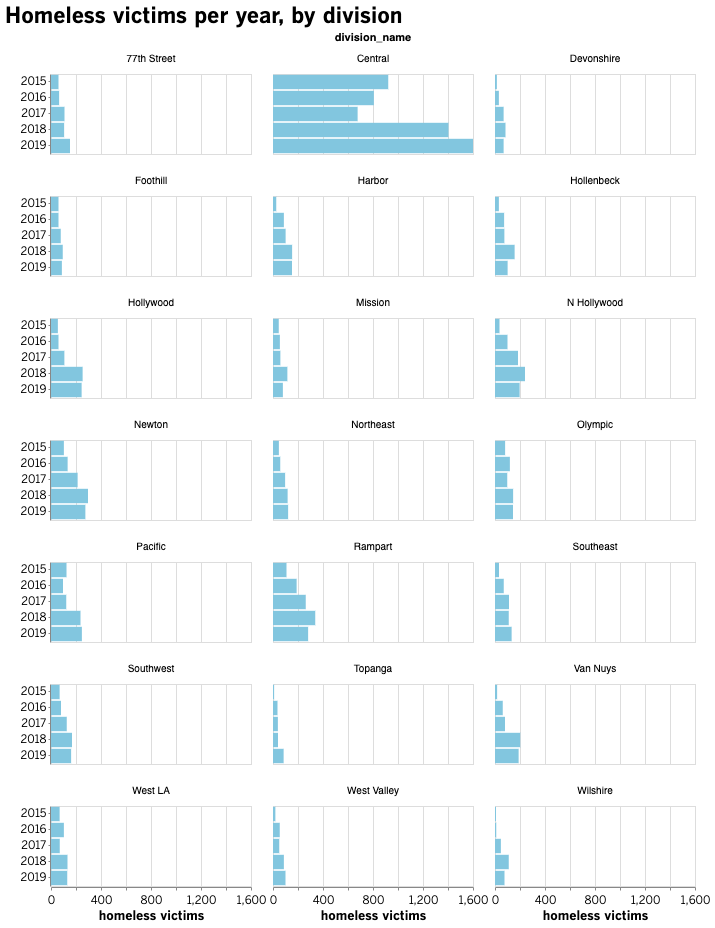

In [34]:
alt.Chart(homeless_year_victim).mark_bar().encode(
    y=alt.Y('year:N', title='', axis=alt.Axis(format='', tickCount=5)),
    x=alt.X("sum(total):Q", title="homeless victims", axis=alt.Axis(format='', tickCount=10)),
    facet='division_name:N'
).properties(height=80, width=200, columns=3, title='Homeless victims per year, by division')

### Homeless victims in central

In [35]:
homeless_victims_central = homeless_victims[homeless_victims['division_name'] == 'Central']

In [36]:
homeless_cases_victim_central = homeless_victims_central.groupby(['crime_code_description'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)

In [37]:
homeless_cases_victim_central.head()

,crime_code_description,total
2,"Assault with deadly weapon, aggravated assault",1159
4,Battery - simple assault,1036
52,Theft plain - petty ($950 & under),892
40,Robbery,618
28,Intimate partner - simple assault,354


---

In [38]:
homeless_cases_suspect = homeless_suspects.groupby(['crime_code_description'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)

In [39]:
homeless_cases_suspect.head(10)

,crime_code_description,total
2,"Assault with deadly weapon, aggravated assault",4767
4,Battery - simple assault,4627
97,Trespassing,2840
76,Robbery,2730
80,Shoplifting - petty theft ($950 & under),2532
55,Intimate partner - simple assault,1991
99,"Vandalism - felony ($400 & over, all church va...",1493
90,Theft plain - petty ($950 & under),1235
32,Criminal threats - no weapon displayed,1145
14,Burglary,1136


--- 

## Basic aggregates on variables for all crimes

### Which crimes are most common? 

In [40]:
violations = crimes.groupby(['crime_code_description'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)

In [41]:
violations.head(10)

,crime_code_description,total
5,Battery - simple assault,186633
22,Burglary from vehicle,158361
136,Vehicle - stolen,156154
118,Theft plain - petty ($950 & under),146185
21,Burglary,144622
116,Theft of identity,123841
75,Intimate partner - simple assault,111983
132,"Vandalism - felony ($400 & over, all church va...",106721
3,"Assault with deadly weapon, aggravated assault",90440
133,Vandalism - misdeameanor ($399 or under),88862


### Places where crimes occur?

In [42]:
places = crimes.groupby(['premises_description'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)

In [43]:
places.head(10)

,premises_description,total
278,Street,461267
267,Single family dwelling,417827
211,"Multi-unit dwelling (apartment, duplex, etc)",259470
233,Parking lot,146340
266,Sidewalk,103404
224,Other business,94124
311,"Vehicle, passenger/truck",77957
64,Driveway,41660
80,Garage/carport,36764
258,Restaurant/fast food,28428


### Areas of the city? 

In [44]:
divisions = crimes.groupby(['division_name'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)

In [45]:
divisions.head(10)

,division_name,total
0,77th Street,142045
15,Southwest,132261
8,N Hollywood,111182
12,Pacific,109615
14,Southeast,108814
7,Mission,101307
10,Northeast,97969
9,Newton,97494
17,Van Nuys,97282
6,Hollywood,96352


### What kinds of weapons?

In [46]:
weapons = crimes.groupby(['weapon_description'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)

In [47]:
weapons.head(10)

,weapon_description,total
65,"Strong-arm (hands, fist, feet or bodily force)",420047
78,Verbal threat,57315
75,Unknown weapon/other weapon,55848
27,Hand gun,33292
58,Semi-automatic pistol,12662
32,Knife with blade 6inches or less,12527
44,Other knife,9521
73,Unknown firearm,7728
77,Vehicle,7076
50,Revolver,5496


### Which days of the week?

In [48]:
weekdays = crimes.groupby(['weekday'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)

In [49]:
weekdays.head(7)

,weekday,total
0,Friday,317192
2,Saturday,296815
1,Monday,293949
6,Wednesday,291986
4,Thursday,290491
5,Tuesday,287999
3,Sunday,283921


---

### Cleaning up modus operandi

In [50]:
# df = crimes[['record_id', 'modus_operandi_code']]

In [51]:
# df['modus_operandi_code'] = df['modus_operandi_code'].dropna().apply(lambda x: x.split(' '))

In [52]:
# final = df['modus_operandi_code'].apply(pd.Series)\
# .merge(df, left_index = True, right_index = True)\
# .drop('modus_operandi_code', axis = 1)\
# .melt(id_vars = ['record_id'], value_name = "modus_operandi_code", var_name = 'modoporder')\
# .dropna(subset=['modus_operandi_code'])\
# .sort_values('record_id')

In [53]:
# mo_counts = final.groupby(['modus_operandi_code']).agg('size')\
# .reset_index(name='count').sort_values(by='count', ascending=False)

In [54]:
# merged_mo_counts = pd.merge(mo_counts, mocodes, 
#                      left_on = 'modus_operandi_code', 
#                      right_on = 'mo_code', 
#                      how='left')

In [55]:
# merged_mo_counts.head()